# XGBoost

In [12]:
import pandas as pd

# Set to see all columns
pd.set_option('display.max_columns', None)

# Set to see all rows
#pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns

from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
csv_file = 'data/01_bronze/2009.csv'
df_2009 = pd.read_csv(csv_file)
df_2009 = df_2009[df_2009['DEP_DELAY'].notna()]
df_2009 = df_2009[df_2009['ORIGIN']=='JFK']
df_2009.shape

(117070, 28)

In [3]:
csv_file = 'data/01_bronze/2010.csv'
df_2010 = pd.read_csv(csv_file)
df_2010 = df_2010[df_2010['DEP_DELAY'].notna()]
df_2010 = df_2010[df_2010['ORIGIN']=='JFK']
df_2010.shape

(108341, 28)

In [33]:
df = pd.concat([df_2009, df_2010])
df.shape

(225411, 28)

In [89]:
dep_delay = df[['FL_DATE','DEP_DELAY']]

dep_delay.columns = ['date', 'dep_delay']
print(dep_delay.info())
dep_delay.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225411 entries, 1073 to 6449840
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       225411 non-null  object 
 1   dep_delay  225411 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.2+ MB
None


,date,dep_delay
1073,2009-01-01,-4.0
1074,2009-01-01,-10.0
1495,2009-01-01,0.0
1504,2009-01-01,0.0
1515,2009-01-01,0.0


In [90]:
dep_delay['date'] = pd.to_datetime(dep_delay['date'].str[:10])
print(dep_delay.info())
dep_delay.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225411 entries, 1073 to 6449840
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       225411 non-null  datetime64[ns]
 1   dep_delay  225411 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.2 MB
None


,date,dep_delay
1073,2009-01-01,-4.0
1074,2009-01-01,-10.0
1495,2009-01-01,0.0
1504,2009-01-01,0.0
1515,2009-01-01,0.0


In [91]:
mean_dep_delay = dep_delay.groupby(['date'])\
    .agg(mean_dep_delay=('dep_delay', 'mean'))\

mean_dep_delay

,mean_dep_delay
date,
2009-01-01,12.376623
2009-01-02,16.485893
2009-01-03,19.686084
2009-01-04,17.434921
2009-01-05,13.993651
...,...
2010-12-27,110.333333
2010-12-28,151.675676
2010-12-29,80.518797


<AxesSubplot:xlabel='date'>

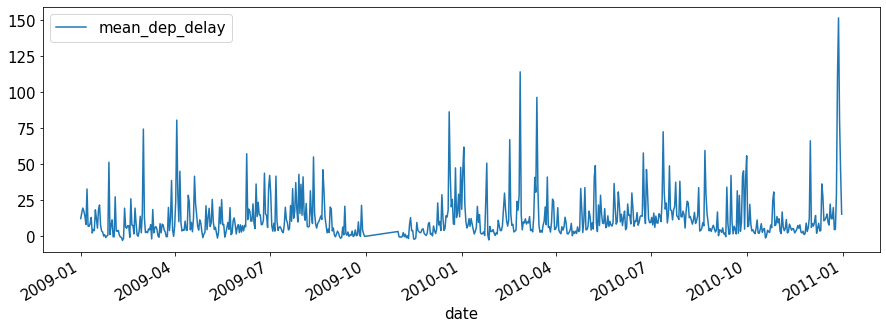

In [92]:
plt.rc('figure',figsize=(15,5))
#plt.rc('font',size=15)
mean_dep_delay.plot()

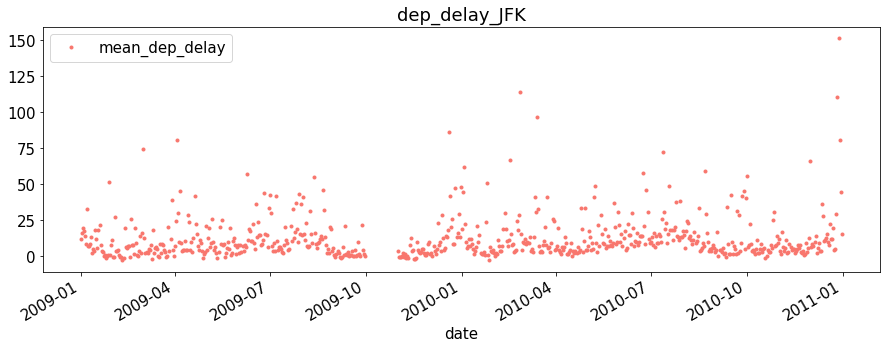

In [93]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = mean_dep_delay.plot(style='.', figsize=(15,5), color=color_pal[0], title='dep_delay_JFK')

In [94]:
mean_dep_delay.reset_index(inplace=True)
mean_dep_delay

,date,mean_dep_delay
0,2009-01-01,12.376623
1,2009-01-02,16.485893
2,2009-01-03,19.686084
3,2009-01-04,17.434921
4,2009-01-05,13.993651
...,...,...
694,2010-12-27,110.333333
695,2010-12-28,151.675676
696,2010-12-29,80.518797
697,2010-12-30,45.009709


In [95]:
data_train = mean_dep_delay.loc[:len(mean_dep_delay)*0.8,:].set_index('date')
data_test = mean_dep_delay.loc[len(mean_dep_delay)*0.8:,:].set_index('date')

print(f"Len dataset: {len(mean_dep_delay)}")
print(f"Len train: {len(data_train)}")
print(f"Len test: {len(data_test)}")


Len dataset: 699
Len train: 560
Len test: 139


In [96]:
data_train

,mean_dep_delay
date,
2009-01-01,12.376623
2009-01-02,16.485893
2009-01-03,19.686084
2009-01-04,17.434921
2009-01-05,13.993651
...,...
2010-08-10,8.515528
2010-08-11,11.534161
2010-08-12,16.695513


In [97]:
data_test

,mean_dep_delay
date,
2010-08-15,14.123028
2010-08-16,33.877419
2010-08-17,3.730408
2010-08-18,4.196875
2010-08-19,5.619497
...,...
2010-12-27,110.333333
2010-12-28,151.675676
2010-12-29,80.518797


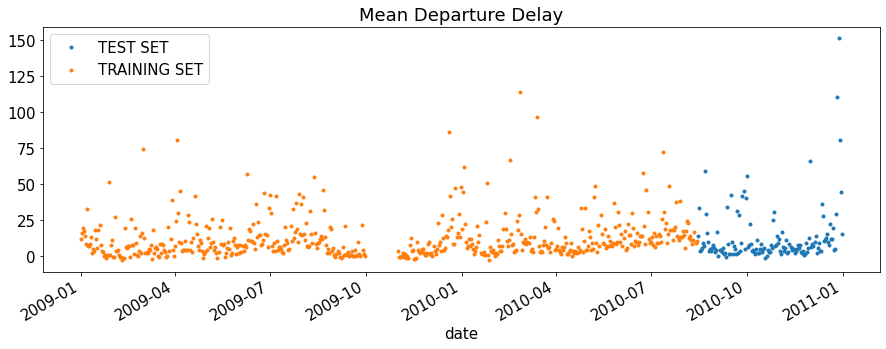

In [99]:
_ = data_test.rename(columns={'mean_dep_delay': 'TEST SET'}) \
    .join(data_train.rename(columns={'mean_dep_delay': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Mean Departure Delay', style='.')

In [100]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [101]:
X_train, y_train = create_features(data_train, label='mean_dep_delay')
X_test, y_test = create_features(data_test, label='mean_dep_delay')

In [102]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2009-01-01,0,3,1,1,2009,1,1,1
2009-01-02,0,4,1,1,2009,2,2,1
2009-01-03,0,5,1,1,2009,3,3,1
2009-01-04,0,6,1,1,2009,4,4,1
2009-01-05,0,0,1,1,2009,5,5,2
...,...,...,...,...,...,...,...,...
2010-08-10,0,1,3,8,2010,222,10,32
2010-08-11,0,2,3,8,2010,223,11,32
2010-08-12,0,3,3,8,2010,224,12,32


In [103]:
X_test

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2010-08-15,0,6,3,8,2010,227,15,32
2010-08-16,0,0,3,8,2010,228,16,33
2010-08-17,0,1,3,8,2010,229,17,33
2010-08-18,0,2,3,8,2010,230,18,33
2010-08-19,0,3,3,8,2010,231,19,33
...,...,...,...,...,...,...,...,...
2010-12-27,0,0,4,12,2010,361,27,52
2010-12-28,0,1,4,12,2010,362,28,52
2010-12-29,0,2,4,12,2010,363,29,52


In [104]:
y_train

date
2009-01-01    12.376623
2009-01-02    16.485893
2009-01-03    19.686084
2009-01-04    17.434921
2009-01-05    13.993651
                ...    
2010-08-10     8.515528
2010-08-11    11.534161
2010-08-12    16.695513
2010-08-13     8.978395
2010-08-14    10.895973
Name: mean_dep_delay, Length: 560, dtype: float64

In [105]:
y_test

date
2010-08-15     14.123028
2010-08-16     33.877419
2010-08-17      3.730408
2010-08-18      4.196875
2010-08-19      5.619497
                 ...    
2010-12-27    110.333333
2010-12-28    151.675676
2010-12-29     80.518797
2010-12-30     45.009709
2010-12-31     15.437063
Name: mean_dep_delay, Length: 139, dtype: float64

In [106]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [107]:
# Instantiating our model
reg = xgb.XGBRegressor(n_estimators=1000)

In [108]:
# Fitting our data into the model.
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [142]:
# Importancia predictores
# ==============================================================================
#importancia = reg.get_feature_importance()


importancia = reg.get_booster().get_score(importance_type="gain")
importancia

#clf.get_booster().get_score(importance_type="gain")

{'dayofweek': 44.625640869140625,
 'quarter': 35.11642074584961,
 'month': 36.39314270019531,
 'year': 76.44749450683594,
 'dayofyear': 105.9094467163086,
 'dayofmonth': 88.31697082519531,
 'weekofyear': 129.8094940185547}

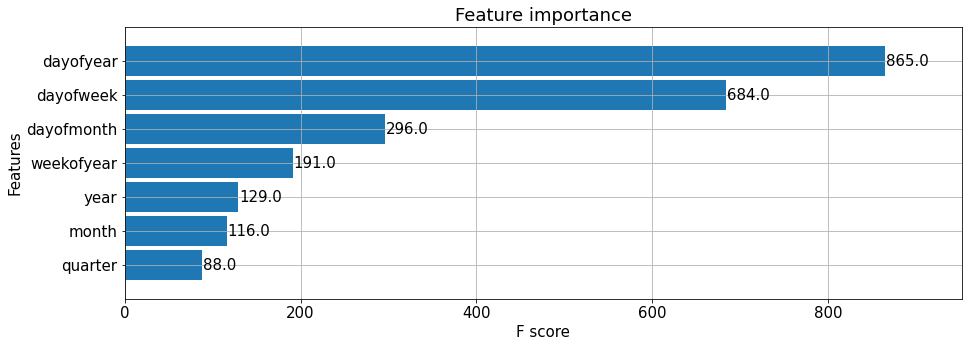

In [140]:
_ = plot_importance(reg, height=0.90)

## Forecasting

In [110]:
data_test['mean_dep_delay_Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [115]:
data_test
#data_train
data_all

,mean_dep_delay,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,mean_dep_delay_Prediction
date,,,,,,,,,,,
2010-08-15,14.123028,2010-08-15,0,6,3,8,2010,227,15,32,15.796955
2010-08-16,33.877419,2010-08-16,0,0,3,8,2010,228,16,33,16.991219
2010-08-17,3.730408,2010-08-17,0,1,3,8,2010,229,17,33,14.813660
2010-08-18,4.196875,2010-08-18,0,2,3,8,2010,230,18,33,15.614764
2010-08-19,5.619497,2010-08-19,0,3,3,8,2010,231,19,33,15.614764
...,...,...,...,...,...,...,...,...,...,...,...
2010-08-10,8.515528,2010-08-10,0,1,3,8,2010,222,10,32,NaN
2010-08-11,11.534161,2010-08-11,0,2,3,8,2010,223,11,32,NaN
2010-08-12,16.695513,2010-08-12,0,3,3,8,2010,224,12,32,NaN


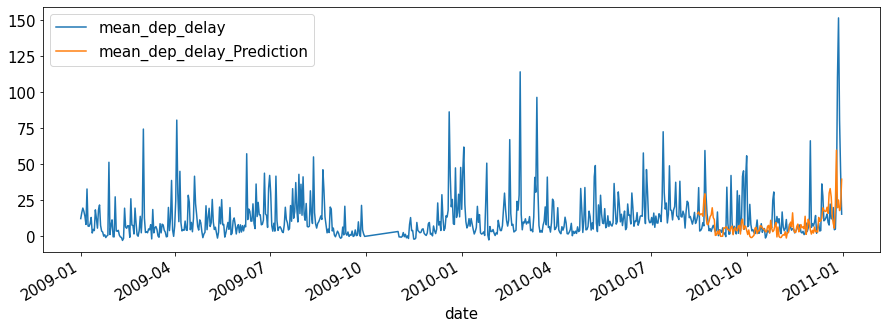

In [111]:
# Now lets plot our prediction

_ = data_all[['mean_dep_delay','mean_dep_delay_Prediction']].plot(figsize=(15, 5))

In [144]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rmse = lambda act, pred: np.sqrt(mean_squared_error(act, pred))


actual_data = data_test['mean_dep_delay']
predicted_data = data_test['mean_dep_delay_Prediction']

# Error metrics
print(f'RMSE: {rmse(actual_data, predicted_data)}')
print(f'MAPE: {mean_absolute_percentage_error(actual_data, predicted_data)}')
print(f'MAE: {mean_absolute_error(actual_data, predicted_data)}')

RMSE: 19.43716309051987
MAPE: 1.2588965809976365
MAE: 10.30193024343478


In [118]:
#Accuracy
from sklearn.metrics import accuracy_score

## Continuar desde acá

In [134]:
## Aca es donde me di cuenta que utilice XGBoost para hacer "regresion" y no "clasificacion" 
## que es lo que necesito para deteccion de anomalias
y_pred = data_test['mean_dep_delay_Prediction'].copy()

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

ValueError: continuous is not supported